In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Figure out path to pwd and data dir
_pwd = os.path.abspath("..")
_data_dir = os.path.join(_pwd, "data")

In [3]:
_perf_dir = os.path.join(_data_dir, 'perf_results_droidkungfu')
_avail_apps = os.listdir(_perf_dir)
_fname = "result.csv"
_perf_files = list(map(lambda app: os.path.join(_perf_dir, app + "/" + _fname), _avail_apps))
print(f"There are {len(_avail_apps)} apps with performance results")


There are 9 apps with performance results


In [4]:
all_dfs = list(map(lambda perf: pd.read_csv(perf), _perf_files))

In [5]:
print(all_dfs)

[      branch-load-misses  branch-loads  dTLB-loads  dTLB-stores  iTLB-loads  \
0                      0             0           0            0         632   
1                      0             0           0            0      819917   
2                      0             0           0            0     1577091   
3                      0             0           0            0     2361985   
4                      0             0           0            0     3161108   
...                  ...           ...         ...          ...         ...   
3611             4300481     146523657   341416957    338217295    64514791   
3612             4300481     147415601   343039597    339272017    65049259   
3613             4300481     150958646   348797476    342598926    65412190   
3614             4300481     151687647   351157870    344940564    65854539   
3615             4300481     152848966   352890044    346991168    66271291   

      iTLB-stores  L1-dcache-load-misses  L1-dcach

In [29]:
df = all_dfs[0]

In [17]:
_apks = df['apk'].unique()
_columns = list(df.columns)
_del_columns = ['apk', 'type']

_metrics = _columns
for _col in _del_columns:
    _metrics.remove(_col)
    
print(f"Data contains {_metrics} metrics")

Data contains ['branch-load-misses', 'branch-loads', 'dTLB-loads', 'dTLB-stores', 'iTLB-loads', 'iTLB-stores', 'L1-dcache-load-misses', 'L1-dcache-store-misses', 'L1-dcache-stores', 'L1-icache-load-misses', 'L1-icache-store-misses', 'node-loads', 'node-stores', 'branch-instructions', 'branch-misses', 'instructions'] metrics


In [8]:
labels = [0, 1]
colors = [
    "#4b739d" if l == 0 else "#c74e52" if l == 1 else "#54944c" for l in labels
]

In [9]:
def plot_kmeans(df, metrics):
    df = df[metrics]
    X = np.array(df)
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    df = pd.DataFrame(X)
    df.plot(color=colors, linewidth=0.5, legend=False, alpha=0.25)

In [10]:
def plot_PCA(df, metrics):
    df.type = pd.Categorical(df.type)
    group = df.type.cat.codes

    df = df[metrics]
    X = np.array(df)
    pca = PCA(n_components=2)
    pca.fit(X)
    Y = pca.transform(X)
    plt.figure()
    colors = ['blue', 'red']
    target_names = ['benign', 'malicious']
    lw = 2

    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(
            Y[group[0:len(Y)] == i, 0],
            Y[group[0:len(Y)] == i, 1],
            color=color,
            alpha=.6,
            lw=lw,
            label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA result for ')

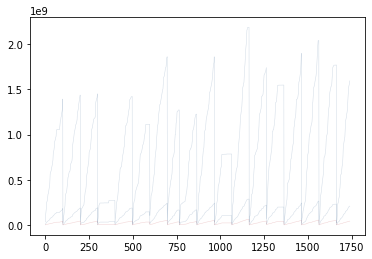

In [11]:
_metrics = ['branch-instructions', 'branch-misses', 'instructions']
# for idx, df in enumerate(all_dfs):
df = all_dfs[0]
b_df = df.loc[df['type'] == "benign"]
m_df = df.loc[df['type'] == "malicious"]
plot_kmeans(b_df, _metrics)

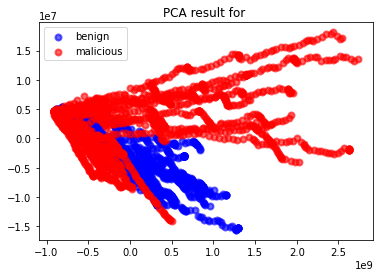

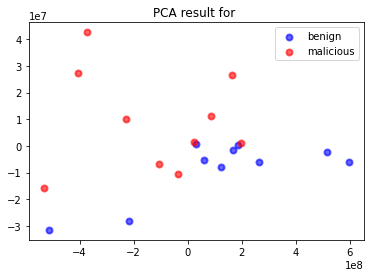

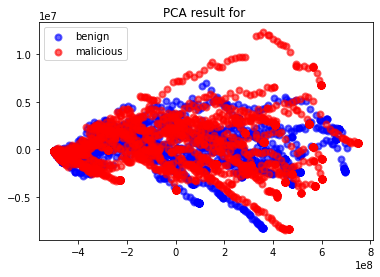

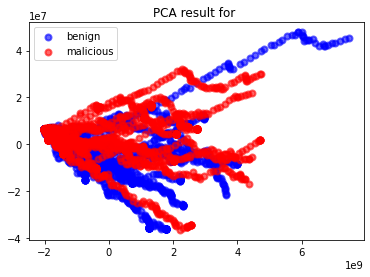

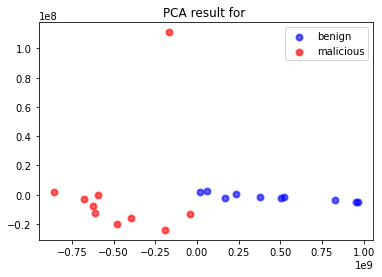

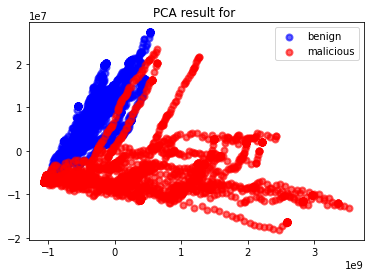

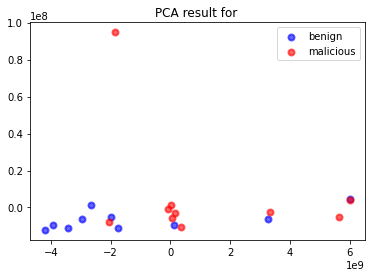

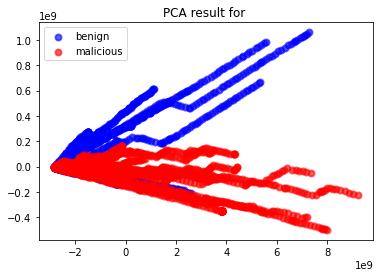

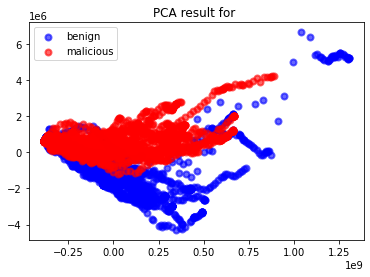

In [12]:
for idx, df in enumerate(all_dfs):
    plot_PCA(df, _metrics)

[0 1]
(3855, 16) (3855,)


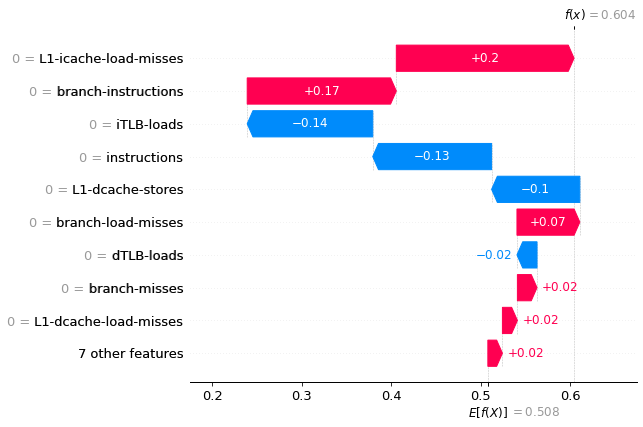

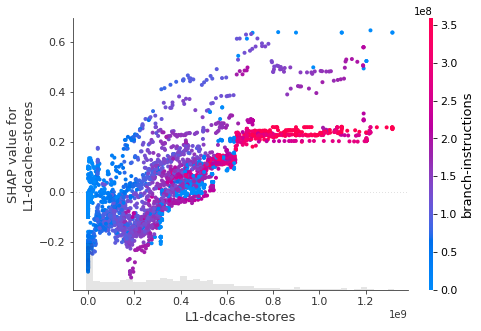

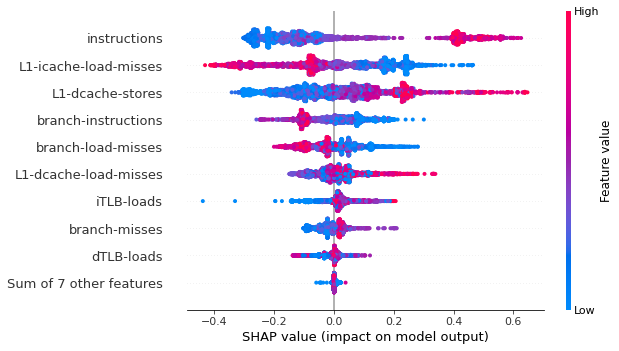

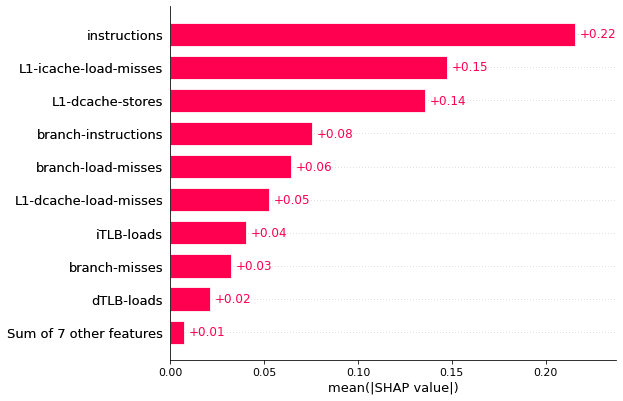

In [59]:
df = all_dfs[5]
import xgboost
import shap

# train an XGBoost model
df["typeX"] = df['type'].astype('category').cat.codes
print(df["typeX"].unique())
X, y = df[_metrics], np.array(df["typeX"])
print(X.shape, y.shape)
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

shap.plots.scatter(shap_values[:,"L1-dcache-stores"], color=shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.bar(shap_values)

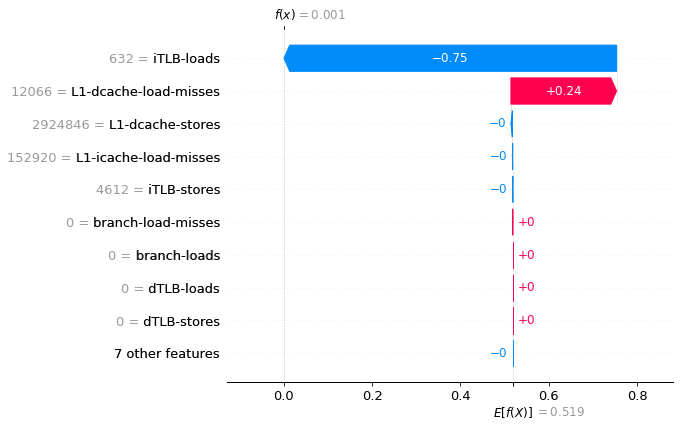

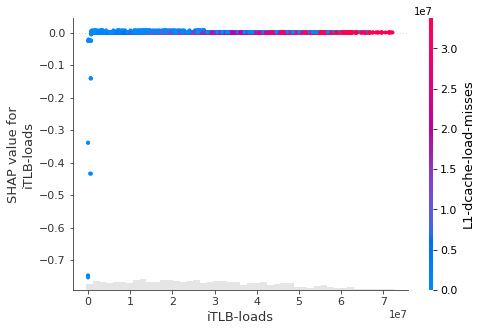

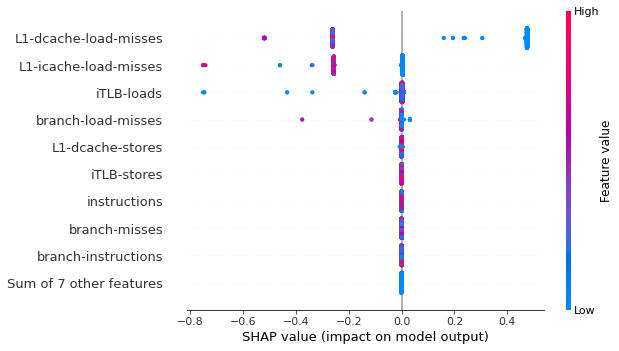

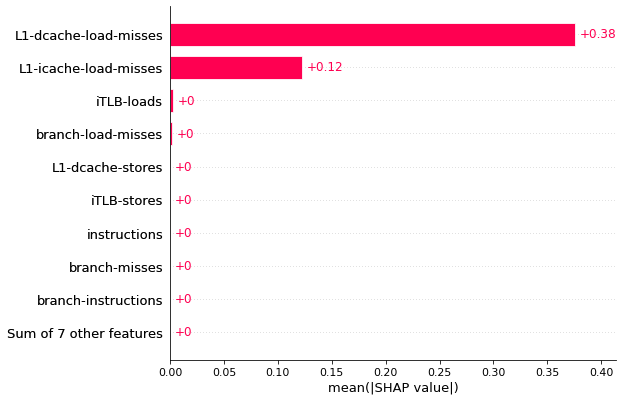